# Train a CNN on LSE cycles for Age prediction from gait

In [1]:
# Imports
import tables
import os
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
np.random.seed(42)

import threading
import pickle
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# =============================================================================
# PARAMETERS
# =============================================================================

#File locations
output_dir = "/scratch/PI/euan/projects/mhc/code/daniel_code/results"
label_table_file = "/scratch/PI/euan/projects/mhc/code/daniel_code/tables/all.tsv"
train_data_path = r"/scratch/PI/euan/projects/mhc/code/daniel_code/data/age_cycles.hdf5"

#Training metrics
model_metrics = ['mse', 'mae']

#Training parameters
batch_size = 512
canMultiprocess = False

# Data visualization and processing

In [3]:
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    print(file)

/scratch/PI/euan/projects/mhc/code/daniel_code/data/age_cycles.hdf5 (File) 'cycles'
Last modif.: 'Fri Jul 12 11:57:58 2019'
Object Tree: 
/ (RootGroup) 'cycles'
/data (EArray(300438, 100, 4)) ''
/labels (EArray(300438,)) ''



(100, 300)


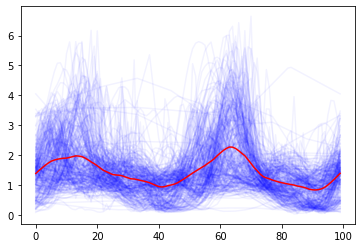

In [4]:
#Visualize some data points
with tables.open_file(train_data_path, mode='r') as file:
    subset = file.root.data[0:300, :, -1].T
    print(subset.shape)
    plt.plot(subset, color='b', alpha=0.05)
    plt.plot(np.mean(subset, axis=1), color ='r')

In [5]:
#Look at our label file
label_df = pd.read_csv(label_table_file, 
                       header=None,
                       names=["Healthcode", "Age", "Gender", "Ethnicity", "Version"], 
                       delimiter='\t')
label_df = label_df.set_index('Healthcode')
label_df
#Access a label like this
print(label_df.loc[label_df.index[0], 'Age'])

Healthcode
d04c954e-979b-4b24-999a-aa4c4a9f90e9    35
d04c954e-979b-4b24-999a-aa4c4a9f90e9    35
Name: Age, dtype: object


(128, 1, 4, 100)


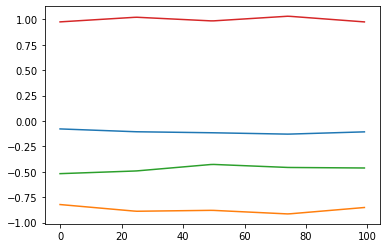

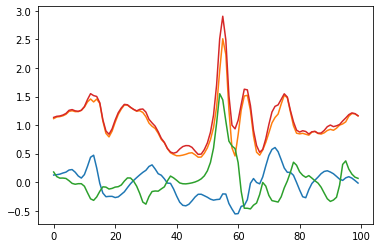

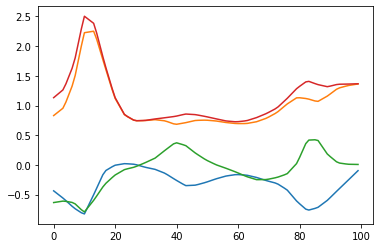

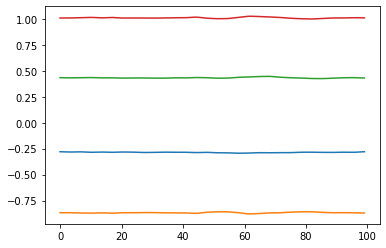

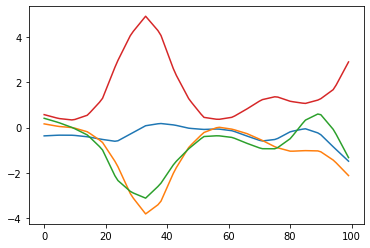

In [43]:
# =============================================================================
# Data generator
# =============================================================================
def extract_labels(label_table_path):
    '''
    Returns a dataframe indexed by healthCodes
    taken from the label table file
    '''
    label_df = pd.read_csv(label_table_path, 
                           header=None,
                           names=["Healthcode", "Age", "Gender", "Ethnicity", "Version"], 
                           delimiter='\t')
    #Encode to bytes
    label_df['Healthcode'] = label_df['Healthcode'].map(lambda x: x.encode('UTF-8'))
    #Drop duplicates
    label_df = label_df.set_index('Healthcode')
    label_df = label_df.loc[~label_df.index.duplicated(keep='first')]
    
    #Drop invalid age values
    label_df = label_df[label_df.Age.apply(lambda x: str(x).isdigit())]
    
    return label_df

def parse_label(code, label_df):
    """
    Helper function that parses the labels on survey data for a given code
    """
    
    return int(label_df.loc[code, 'Age'])
        
class SixMWTSequence(keras.utils.Sequence):
    '''
    SixMWTSequence
    Extends keras inbuilt sequence to create a data generator
    Saves on RAM by loading data from hdf5 files in memory
    Shuffle increases read time by 20x but makes the batches mixed
    '''
    def __init__(self, data_file, batch_size, label_df, shuffle=True, val=False, val_split = 0.7):
        #Open up file
        #self.lock = threading.Lock()
        self.data = data_file.root.data
        self.labels = data_file.root.labels
        
        #Track labels and batch size
        self.label_map = label_df
        self.batch_size = batch_size
        self.inval_hc = set()
        self.val = val
        self.val_split = val_split
        
        #Partition the dataset into batches
        if val:
            num_data = int(self.labels.shape[0] * (1-val_split))
            self.order = np.arange(self.labels.shape[0] - num_data, self.labels.shape[0])
        else:
            num_data = int(self.labels.shape[0] * val_split)
            self.order = np.arange(num_data)
            
        self.length = num_data // self.batch_size
                
        #Shuffle
        if(shuffle):
            np.random.shuffle(self.order)        

    def __len__(self):

        return self.length

    def __getitem__(self, idx):
        
        start_idx = idx*self.batch_size
        stop_idx = (idx + 1)*self.batch_size
                    
        idxs = self.order[start_idx:stop_idx]
        
        #Get the batch members
        batch_x = np.array([self.data[idx] for idx in idxs])
        y_healthcodes = np.array([self.labels[idx] for idx in idxs])
                
        #Convert healthcodes to ages
        batch_y = np.empty(len(y_healthcodes))
        for i in range(len(batch_y)):
            
            batch_y[i] = parse_label(y_healthcodes[i], self.label_map)
                
        #Normalize over time dimension
        #print(np.mean(batch_x, axis = -2))

        #batch_x -= np.expand_dims(np.mean(batch_x, axis = 1), axis=1)
        #batch_x = keras.utils.normalize(batch_x, axis=2)
        #print(np.mean(batch_x, axis = -2))
            
        #Add a extra dimension
        batch_x = np.expand_dims(batch_x, axis=1)
        #Swap axes
        batch_x = np.swapaxes(batch_x, -1, -2)
            
        return batch_x, batch_y

label_df = extract_labels(label_table_file)
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)    
    print(train_gen[20][0].shape)
    window = train_gen[20][0]
    
    for i in range(5):
        plt.figure()
        plt.plot(window[i, :, :].squeeze().T)
        plt.show()

In [44]:
#Make a baby validation dataset in memory for tensorboard callback
X_val = np.empty((0, 1, 4, 100))
y_val = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)  
    for batch_x, batch_y in val_gen:
        X_val = np.concatenate((X_val, batch_x), axis=0)
        y_val = np.concatenate((y_val, batch_y), axis=0)

In [45]:
#Make a baby train dataset in memory
X_train = np.empty((0, 1, 4, 100))
y_train = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)  
    for batch_x, batch_y in train_gen:
        X_train = np.concatenate((X_train, batch_x), axis=0)
        y_train = np.concatenate((y_train, batch_y), axis=0)

In [46]:
#Remove invalid ages (>100)
mask = y_val <= 100
X_val = X_val[mask]
y_val = y_val[mask]

mask = y_train <= 100
X_train = X_train[mask]
y_train = y_train[mask]

In [47]:
print(train_gen.inval_hc, val_gen.inval_hc)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(np.unique(y_train))

set() set()
(210133, 1, 4, 100) (90112, 1, 4, 100) (210133,) (90112,)
[17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 80. 81. 82. 85. 86.]


[(37.0, 3751), (59.0, 4034), (53.0, 6812), (35.0, 3925), (61.0, 4484), (36.0, 7983), (34.0, 5332), (25.0, 1875), (43.0, 4223), (50.0, 4340), (55.0, 3964), (54.0, 11304), (38.0, 4826), (58.0, 6065), (33.0, 6307), (22.0, 2631), (60.0, 3412), (32.0, 6439), (69.0, 2826), (31.0, 7783), (56.0, 1985), (80.0, 374), (70.0, 3349), (28.0, 3497), (24.0, 5527), (27.0, 4954), (47.0, 1007), (57.0, 4733), (21.0, 1283), (29.0, 2654), (44.0, 3072), (45.0, 3521), (65.0, 1862), (51.0, 1416), (68.0, 1408), (63.0, 2915), (64.0, 5206), (66.0, 3123), (23.0, 2013), (72.0, 2506), (62.0, 1764), (48.0, 2304), (52.0, 1831), (40.0, 5213), (30.0, 7859), (17.0, 247), (73.0, 694), (49.0, 1811), (39.0, 1050), (71.0, 1463), (77.0, 3698), (67.0, 2033), (42.0, 3162), (41.0, 6105), (46.0, 3286), (76.0, 1605), (19.0, 289), (74.0, 480), (20.0, 1122), (86.0, 219), (18.0, 1190), (26.0, 1852), (81.0, 702), (78.0, 427), (85.0, 340), (75.0, 441), (82.0, 225)]


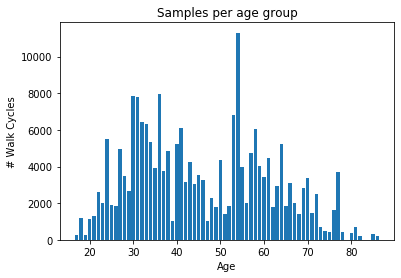

In [55]:
from collections import Counter
xs = []
ys = []
print(list(Counter(y_train).items()))
for item in Counter(y_train).items():
    xs.append(item[0])
    ys.append(item[1])

plt.figure()
plt.title("Samples per age group")
plt.bar(xs, ys)
plt.xlabel("Age")
plt.ylabel("# Walk Cycles")
plt.show()

In [50]:
np.save('age_X_train.npy', X_train)
np.save('age_X_val.npy', X_val)
np.save('age_y_train.npy', y_train)
np.save('age_y_val.npy', y_val)

In [7]:
# =============================================================================
# OLD: Generator-based training
# =============================================================================

with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)    
    
    num_train = len(train_gen)
    num_val = len(val_gen)
    print("There are {} training batches and {} validation batches".format(num_train, num_val))
    
    num_epochs = 1000
    
    #Calculate class weights from 100 batches
    temp = np.array([])
    num_smpls = min(100, num_train)
    rand_idxs = random.sample(list(range(num_train)), num_smpls)
    for batch_num in rand_idxs:
        _, temp_y = train_gen[batch_num]
        temp = np.concatenate((temp, temp_y))
    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                     np.unique(temp),
                                                     temp)))
    
    print("Our class weights are {}".format(class_weights))
    #Training

#    history = model.fit_generator(generator=train_gen,
#                              epochs=num_epochs,
#                              callbacks = cb_list,
#                              validation_data=val_gen,
#                              class_weight=class_weights,
#                              shuffle=True)

There are 1659 training batches and 711 validation batches
Our class weights are {0: 1.6218955904713634, 1: 0.7228371357578496}


# Training

In [14]:
#Load three axis data (OLD)
X_train = np.load('age_X_train.npy')
y_train = np.load('age_y_train.npy')

X_val = np.load('age_X_val.npy')
y_val = np.load('age_y_val.npy')

In [3]:
#Load 15 axis data
print('Beginning loading')
X_train = np.load('age_X_15.npy')
y_train = np.load('age_y_15.npy')
ids_train = np.load('age_ids_15.npy')

print('Finished loading, beginning X_train axis adjustment')

#Change X_train to weird format
X_train = np.expand_dims(X_train, 1)
X_train = np.swapaxes(X_train, -1, -2)

#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(X_train, y_train, ids_train, train_size = 0.8)

#Randomize
if False:
    print('Data will be randomized.')
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]
    ids_train = ids_train[idxs]
else:
    print('Data is NOT randomized.')

print('Beginning data splitting')

split_num = int(0.8*X_train.shape[0])
X_val = X_train[split_num:]
y_val = y_train[split_num:]
ids_val = ids_train[split_num:]

X_train = X_train[:split_num]
y_train = y_train[:split_num]
ids_train = ids_train[:split_num]

X_train.shape, X_val.shape, y_train.shape, y_val.shape, ids_train.shape, ids_val.shape

Beginning loading
Finished loading, beginning X_train axis adjustment
Data is NOT randomized.
Beginning data splitting


((2545121, 1, 15, 100),
 (636281, 1, 15, 100),
 (2545121,),
 (636281,),
 (2545121,),
 (636281,))

In [5]:
#Define a model
def get_model():
    model = Sequential()
    # ENTRY LAYER
    model.add(Conv1D(32, 10, activation='relu', input_shape=(100, 4)))
    model.add(BatchNormalization())

    for i in range(5):
    
        model.add(Conv1D(64, 5, activation='relu'))
        model.add(BatchNormalization())

    model.add(Conv1D(128, 10, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv1D(128, 10, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(40, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

In [6]:
import functools
from typing import Callable, Tuple, Union

import keras.backend as K
from keras.layers import (
    AveragePooling2D,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    LocallyConnected2D,
    MaxPooling2D,
    Permute,
    add,
    concatenate,
    regularizers,
    Reshape,
)


from keras.models import Model

D_FMT = dict(data_format='channels_first')
REG_P = dict(kernel_regularizer=regularizers.l2(0.001))
ACT_P = dict(activation='selu', **REG_P)
BN_P = dict(epsilon=0.23, axis=-1)

def VinNet(input_shape=None, input_tensor=(None, None), classes=1000, dropout=0.3, factor=2):  # noqa: ignore=N802
    """
    VinNet Architecture

    # Arguments
        input_shape: shape tuple
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        classes: optional number of classes to classify images
        dropout: dropout applied to fc layers
        factor: scaling factor to reduce network filter width

    # Returns
        A Keras model instance.
    """
    assert input_shape or all(input_tensor), f'Must provide at least one: input_shape, input_tensor'

    # Inputs
    acc_input = _create_input(input_shape=input_shape, name='acc_input')

    # Accelerometer and Conv Blocks
    x = _vinnet_body(sensor='acc')(acc_input)

    # Classification block
    x = Dense(classes, name='predictions', **REG_P)(x)

    return Model(inputs=acc_input, outputs=x, name='VinNet')

def _create_input(input_shape, input_tensor=None, name='input'):
    """
    Select a correct input tensor based on shape and instance specification.

    # Arguments
        input_shape: Input shape tuple
        input_tensor: Existing tensor to wrap into the `Input` layer.
                      If set, the layer will not create a placeholder tensor.
        name: Name string for layer.

    # Returns
        Input Tensor
    """
    if input_tensor is None:
        return Input(shape=input_shape, name=name)

    if not K.is_keras_tensor(input_tensor):
        return Input(tensor=input_tensor, shape=input_shape, name=name)

    return input_tensor

def _vinnet_body(sensor='acc'):

    def layer_wrapper(inp):
        lower = _fc_lower(sensor=sensor)(inp)
        lc = _flatten_lc(sensor=sensor)(inp)

        concat = concatenate([lower, lc], axis=-1, name=f'concat_{sensor}')

        x = Dense(512, name=f'dense_top_{sensor}', **ACT_P)(concat)
        x = BatchNormalization(name=f'bn_top_{sensor}', **BN_P)(x)

        return x

    return layer_wrapper


def _fc_lower(sensor='acc'):

    _block = functools.partial(_conv_block, sensor=sensor)

    def layer_wrapper(inp):
        c1 = _block(64, (1, 5), block=1, layer=1, padding='valid')(inp)
        c2 = _block(64, (4, 5), block=1, layer=2, padding='valid')(c1)
        c3 = _block(64, (1, 4), block=1, layer=3, padding='same')(c2)
        x = add([c2, c3], name=f'block1_resid1_{sensor}')

        for i in range(2, 6):
            c = _block(64, (1, 8), block=i, layer=1, padding='same')(x)
            x = add([x, c], name=f'block{i}_resid1_{sensor}')

        x = Reshape((1, 64, 92), name=f'reshape_fc_{sensor}')(x)
        x = Conv2D(32, (1, 8), padding='same', name=f'conv_fc_{sensor}', **ACT_P)(x)
        x = Flatten(name=f'flatten_fc_{sensor}', **D_FMT)(x)
        x = Dense(512, name=f'dense_fc_{sensor}', **ACT_P)(x)

        return x

    return layer_wrapper


def _flatten_lc(sensor='acc'):

    def layer_wrapper(inp):
        x = AveragePooling2D(pool_size=(1, 4), strides=(1, 3), name=f'avgpool_lc_{sensor}', **D_FMT)(inp)
        x = LocallyConnected2D(16, (4, 4), strides=(1, 4), name=f'local_lc_{sensor}', **ACT_P, **D_FMT)(x)
        x = Flatten(name=f'flat_lc_{sensor}', **D_FMT)(x)
        x = Reshape((16 * 8,), name=f'reshape_lc_{sensor}')(x)
        return x

    return layer_wrapper


def _conv_layer(units, kernel_size=(1, 3), block=1, layer=1, padding='valid', sensor='acc'):

    def layer_wrapper(inp):
        x = Conv2D(units, kernel_size,
                   padding=padding,
                   name=f'block{block}_conv{layer}_{sensor}', **D_FMT, **ACT_P)(inp)
        return x

    return layer_wrapper


def _conv_block(units, kernel_size=(1, 3), block=1, layer=1, padding='valid', sensor='acc'):
    """
        # Arguments
            units: conv filters
            block: block number within network (used for naming)
            layer: layer number within block (used for naming)
            sensor: sensor name (used for naming)

        # Returns
            callable
    """

    def layer_wrapper(inp):
        x = _conv_layer(units, kernel_size, block, layer, padding, sensor)(inp)
        x = BatchNormalization(name=f'block{block}_bn{layer}_{sensor}', **BN_P)(x)
        return x

    return layer_wrapper

In [4]:
import functools
import json

import keras.backend as K

from keras.layers import Permute, Dense, Input, Conv2D, concatenate, MaxPooling2D
from keras.layers import ELU, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model

# %load model_util
from keras.layers import Input

def _create_input(input_shape, input_tensor=None, name='input'):
    """
    Select a correct input tensor based on shape and instance specification.

    # Arguments
        input_shape: Input shape tuple
        input_tensor: Existing tensor to wrap into the `Input` layer.
                      If set, the layer will not create a placeholder tensor.
        name: Name string for layer.

    # Returns
        Input Tensor
    """
    if input_tensor is None:
        return Input(shape=input_shape, name=name)

    if not K.is_keras_tensor(input_tensor):
        return Input(tensor=input_tensor, shape=input_shape, name=name)

    return input_tensor


def _conv_block(units, block=1, layer=1, sensor='acc'):
    """
    Create VGG style convolutional block.

    Deviations from original paper.
        - Remove `Dropout`
        - Added `BatchNormalization`
        - He-normal initialization
        - Uses `ELU` Activation
        
    # Arguments
        units: conv filters
        block: block number within network (used for naming)
        layer: layer number within block (used for naming)
        sensor: sensor name (used for naming)
        
    # Returns
        callable
    """
    def layer_wrapper(inp):
        x = Conv2D(units, (1, 3), padding='same', kernel_initializer='he_normal',
                   name=f'block{block}_conv{layer}_{sensor}')(inp)
        x = BatchNormalization(epsilon=0.23, name=f'block{block}_bn{layer}_{sensor}')(x)
        x = ELU(name=f'block{block}_act{layer}_{sensor}')(x)
        return x

    return layer_wrapper


def _dense_block(units, dropout=0.3, name='fc1'):
    """
    Create VGG fully connected block.

    # Deviations from original paper.
        - Added `BatchNormalization`
        - Uses `ELU` Activation
    
    # Arguments
        units: fc layer dimensionality
        dropout: dropout probability
        name: prefix for dense layers

    # Returns
        callable
    """

    def layer_wrapper(inp):
        x = Dense(units, name=f'{name}')(inp)
        x = BatchNormalization(epsilon=0.23, name=f'{name}_bn')(x)
        x = ELU(name=f'{name}_act')(x)
        x = Dropout(dropout, name=f'{name}_dropout')(x)
        return x

    return layer_wrapper


def _vgg_body(factor=2, sensor='acc'):
    """
    VGG Network Body containing convolutional blocks
    
    # Arguments
        factor: scaling factor to reduce network filter width
        sensor: sensor name
        
    # Return
        callable
    """

    _vgg_conv_block = functools.partial(_conv_block, sensor=sensor)

    def layer_wrapper(inp):
        x = Permute((1, 3, 2), name=f'swapaxes_{sensor}')(inp)

        # Block 1
        x = _vgg_conv_block(64 // factor, block=1, layer=1)(x)
        x = _vgg_conv_block(64 // factor, block=1, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block1_pool_{sensor}')(x)

        # Block 2
        x = _vgg_conv_block(128 // factor, block=2, layer=1)(x)
        x = _vgg_conv_block(128 // factor, block=2, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block2_pool_{sensor}')(x)

        # Block 3
        x = _vgg_conv_block(256 // factor, block=3, layer=1)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=2)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block3_pool_{sensor}')(x)

        # Block 4
        x = _vgg_conv_block(512 // factor, block=4, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block4_pool_{sensor}')(x)

        # Block 5
        x = _vgg_conv_block(512 // factor, block=5, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block5_pool_{sensor}')(x)

        return x

    return layer_wrapper

def VGG16Net(input_shape=None, input_tensor=(None, None),
             classes=1000, dropout=0.3, factor=2, regression=False):
    """
    Modified VGG architecture
        https://arxiv.org/abs/1409.1556

    # Arguments
        input_shape: shape tuple
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        classes: optional number of classes to classify images
        dropout: dropout applied to fc layers
        factor: scaling factor to reduce network filter width
        regression: whether last layer is regression predictor. If true, ignores the classes argument

    # Returns
        A Keras model instance.
    """
    assert input_shape or all(input_tensor), f'Must provide at least one: input_shape, input_tensor'

    # Two Inputs
    img_input_acc = _create_input(input_shape, input_tensor=input_tensor[0], name='acc_input')

    # Accelerometer and Gyroscope Conv Blocks
    x = _vgg_body(factor=factor, sensor='acc')(img_input_acc)

    # Merge and Pool Channels
    x = GlobalAveragePooling2D(name='avgpool')(x)

    # FC Layers
    x = _dense_block(4098 // factor, dropout=dropout, name='fc1')(x)
    x = _dense_block(4098 // factor, dropout=dropout, name='fc2')(x)

    # Classification block'
    if regression:
        x = Dense(1, name='predictions')(x)
        
    else:
        if classes == 2:
            x = Dense(1, activation = 'sigmoid', name='predictions')(x)

        else:
            x = Dense(classes, activation='softmax', name='predictions')(x)

    return Model(img_input_acc, x, name='VGG16Net')

from keras.callbacks import ModelCheckpoint

class MultiGPUCheckpoint(ModelCheckpoint):
    """
    Drop in replacement for `ModelCheckpoint` callback which fixes a bug
    when saving models wrapped in `keras.utils.multi_gpu_model`.

    Please see:
        https://github.com/keras-team/keras/issues/8123#issuecomment-409395274

    Works with both single and multi-gpu configurations.
    """
    def set_model(self, model):
        layer = model.layers[-2]
        if isinstance(layer, Model) and layer.input_names == model.input_names:
            self.model = layer
        else:
            self.model = model
                

In [8]:
#Get a pretrained model and modify
def get_mod_model():
    from keras.models import load_model
    base_model = load_model("DummyModel.h5")
    model = Sequential()
    for layer in base_model.layers[:-2]:
        model.add(layer)
        
    model.add(Dense(1))
    return model

In [5]:
#Set the model up
#model = get_mod_model()
#model = VinNet(input_shape = (1, 4, 100), classes = 1)
model = VGG16Net(input_shape=(1, 15, 100), regression=True)

print(model.summary())

#Define optimizer
adam = keras.optimizers.Adam() #Default lr is 0.001

model.compile(loss='mse',
              optimizer=adam,
              metrics=model_metrics)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
acc_input (InputLayer)       (None, 1, 15, 100)        0         
_________________________________________________________________
swapaxes_acc (Permute)       (None, 1, 100, 15)        0         
_________________________________________________________________
block1_conv1_acc (Conv2D)    (None, 1, 100, 32)        1472      
_________________________________________________________________
block1_bn1_acc (BatchNormali (None, 1, 100, 32)        128       
_________________________________________________________________
block1_act1_acc (ELU)        (None, 1, 100, 32)        0         
_________________________________________________________________
block1_conv2_acc (Con

In [6]:
#Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-7, verbose=1)

early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

#tb = TensorBoard(log_dir=os.path.join(output_dir, 'logs'), 
#                 write_graph=False,) 
                 #histogram_freq=5, 
                 #embeddings_freq=5, 
                 #embeddings_layer_names=['fc1'],
                 #mbeddings_data = X_val)

cb_list = []#[reduce_lr, early_stop]

In [7]:
history = model.fit(x = X_train,
                    y = y_train,
                    epochs=100,
                    validation_data = (X_val, y_val),
                    callbacks = cb_list,
                    shuffle=True,
                    batch_size = batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 2545121 samples, validate on 636281 samples
Epoch 1/100
2545121/2545121 [==============================] - 199s 78us/step - loss: 173.7879 - mean_squared_error: 173.7879 - mean_absolute_error: 10.3172 - val_loss: 249.7816 - val_mean_squared_error: 249.7816 - val_mean_absolute_error: 12.6615
Epoch 2/100
2545121/2545121 [==============================] - 173s 68us/step - loss: 106.0753 - mean_squared_error: 106.0753 - mean_absolute_error: 7.8286 - val_loss: 228.1444 - val_mean_squared_error: 228.1444 - val_mean_absolute_error: 12.2201
Epoch 3/100
2545121/2545121 [==============================] - 172s 68us/step - loss: 87.7946 - mean_squared_error: 87.7946 - mean_absolute_error: 6.9110 - val_loss: 248.8129 - val_mean_squared_error: 248.8129 - val_mean_absolute_error: 12.5799
Epoch 4/100
2545121/2545121 [==============================] - 173s 68us/step - loss: 76.8058 - mean_squared_error: 76.8058 - mean_absolute_error: 6.3136 - val

KeyboardInterrupt: 

# Visualize Results

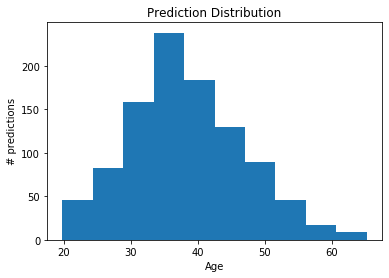

In [8]:
#Example predictions
pred = model.predict(X_val[:1000], batch_size = batch_size)

plt.figure()
plt.title('Prediction Distribution')
plt.xlabel('Age')
plt.ylabel('# predictions')
plt.hist(pred)
plt.show()

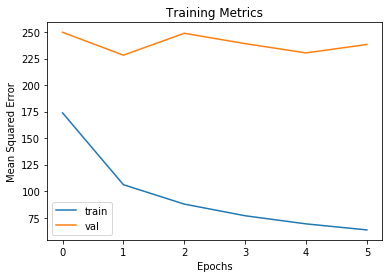

In [9]:
plt.figure()
history = model.history
plt.plot(history.history['mean_squared_error'], label='train')
plt.plot(history.history['val_mean_squared_error'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training Metrics')
plt.show()

In [10]:
y_pred = model.predict(X_train, batch_size = batch_size)

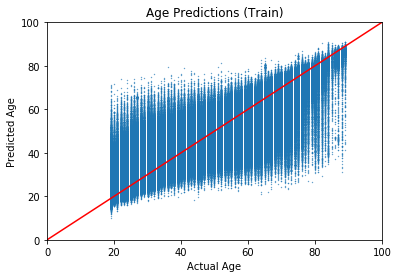

MemoryError: 

In [12]:
plt.figure()
plt.scatter(y_train, y_pred, s=0.1)
plt.plot([0, 100], [0, 100], 'r-')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title("Age Predictions (Train)")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.show()

from scipy import stats
print(stats.spearmanr(y_train, b=y_pred), 
      stats.pearsonr(x=y_train, y=y_pred))

In [16]:
#abs_err = np.abs(np.array(y_train) - np.array(y_pred))
abs_err = 0
for i in range(len(y_train)):
    abs_err += abs(y_train[i] - y_pred[i])
abs_err = abs_err / len(y_train)
print(abs_err)

[5.07361143]


In [17]:
y_pred = model.predict(X_val, batch_size = batch_size)

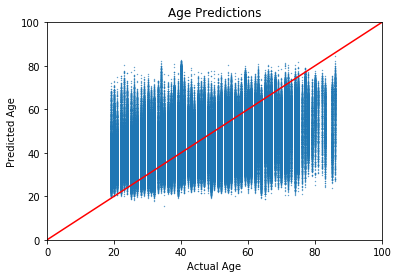

MemoryError: 

In [18]:
plt.figure()
plt.scatter(y_val, y_pred, s=0.1)
plt.plot([0, 100], [0, 100], 'r-')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title("Age Predictions")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.show()

from scipy import stats
print(stats.spearmanr(y_val, b=y_pred), 
      stats.pearsonr(x=y_val, y=y_pred))

In [19]:
#abs_err = np.abs(np.array(y_train) - np.array(y_pred))
abs_err = 0
for i in range(len(y_val)):
    abs_err += abs(y_val[i] - y_pred[i])
abs_err = abs_err / len(y_val)
print(abs_err)

[12.51129532]


# Aggregate user-level predictions

In [20]:
unique_ids = np.unique(ids_val)
print(f'There are {len(unique_ids)} unique ids in our val set.')

overall_y_true = []
overall_y_pred = []

for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(ids_val == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    pred = np.mean(y_pred[usr_idxs])
    true = y_val[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')
    
    overall_y_true.append(true)
    overall_y_pred.append(pred)
    
overall_abs_err = np.abs(np.array(overall_y_true) - np.array(overall_y_pred))

There are 896 unique ids in our val set.


In [21]:
np.mean(overall_abs_err)

11.146491338099752

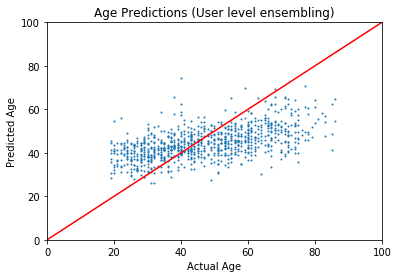

SpearmanrResult(correlation=0.5511141595917486, pvalue=2.5486842626579874e-72) (0.5456883525949381, 1.1554591637803405e-70)


In [22]:
plt.figure()
plt.scatter(overall_y_true, overall_y_pred, s = 1)
plt.plot([0, 100], [0, 100], 'r-')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title("Age Predictions (User level ensembling)")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.show()

from scipy import stats
print(stats.spearmanr(overall_y_true, b=overall_y_pred), 
      stats.pearsonr(x=overall_y_true, y=overall_y_pred))

# That's it folks!

In [ ]:
#Save the model
model.save("Age.h5")